In [57]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats



In [58]:
# Presupunem că fișierul 'greutati.csv' conține o coloană 'weight' cu valorile greutăților peștilor
# Ajustează numele fișierului și coloana la structura ta reală de date

print("Loading data from 'greutati.csv'...")
df = pd.read_csv('greutati.csv')
weights = df['Greutate_pește'].values  # vector numpy de greutăți
print(f"Loaded {len(weights)} data points.")

# Compute mean and standard deviation
data_mean = df['Greutate_pește'].mean()
data_std = df['Greutate_pește'].std()

# Display results
print(f"Mean of data: {data_mean:.2f}")
print(f"Standard deviation of data: {data_std:.2f}")



Loading data from 'greutati.csv'...
Loaded 200 data points.
Mean of data: 62.43
Standard deviation of data: 13.59


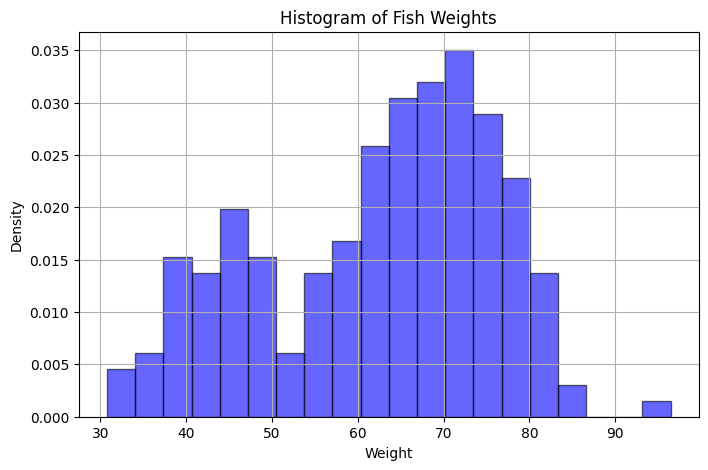

In [59]:
plt.figure(figsize=(8,5))
plt.hist(weights, bins=20, density=True, alpha=0.6, color='blue', edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Density')
plt.title('Histogram of Fish Weights')
plt.grid(True)
plt.show()


In [60]:
def create_and_sample_mixture_model(K, data):
    """
    Creează un mixture model normal cu K subpopulații
    și rulează un sample MCMC foarte scurt (test).
    Returnează InferenceData (trace) și obiectul modelului.
    """
    print(f"\n=== Building Mixture Model with K={K} ===")

    with pm.Model() as model:
        # Prior pentru ponderi (Dirichlet)
        w = pm.Dirichlet('w', a=np.ones(K), shape=K)

        # Prior for means (having the mean and stdev of the data initially, so we can plot the mixtures nicely with few samples size)
        # The prior should actually be something less informative, like mu = pm.Normal("mu", mu=data_mean, sigma=10.0, shape=K) to allow for higher variation
        mu = pm.Normal('mu', mu=data_mean, sigma=data_std, shape=K)

        # Prior pentru deviații standard (HalfNormal)
        sigma = pm.HalfNormal('sigma', sigma=10, shape=K)

        # Folosim pm.NormalMixture care e mai nou in PyMC
        # Observăm datele 'data' prin acest mixture
        y_obs = pm.NormalMixture(
            'y_obs',
            w=w,
            mu=mu,
            sigma=sigma,
            observed=data
        )

        # Sampling foarte scurt, doar pentru a testa că merge
        # În aplicații reale, tune și draws mai mari!
        print(f"Sampling for K={K} ... (short run)")
        trace = pm.sample(
            draws=2,         # FOARTE mic, doar să vedem că rulează
            tune=1,          # FOARTE mic, doar să vedem că rulează
            chains=2,         # numărul de lanțuri
            target_accept=0.8,
            return_inferencedata=True,
            idata_kwargs={"log_likelihood": True}  # necesar pentru compare
        )

    return trace, model


In [61]:
models_traces = {}
models_objs = {}

for k in [3, 4, 5]:
    idata, model = create_and_sample_mixture_model(k, weights)
    models_traces[f"K={k}"] = idata
    models_objs[f"K={k}"] = model



=== Building Mixture Model with K=3 ===


Only 2 samples in chain.


Sampling for K=3 ... (short run)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [w, mu, sigma]


Sampling 2 chains for 1 tune and 2 draw iterations (2 + 4 draws total) took 4 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0, but should be close to 0.8. Try to increase the number of tuning steps.
C:\Users\Victus\AppData\Local\Temp\ipykernel_14580\3594352697.py:32: UserWarning: The number of samples is too small to check convergence reliably.
  trace = pm.sample(
Only 2 samples in chain.



=== Building Mixture Model with K=4 ===
Sampling for K=4 ... (short run)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [w, mu, sigma]


Sampling 2 chains for 1 tune and 2 draw iterations (2 + 4 draws total) took 4 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0, but should be close to 0.8. Try to increase the number of tuning steps.
Only 2 samples in chain.



=== Building Mixture Model with K=5 ===
Sampling for K=5 ... (short run)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [w, mu, sigma]


Sampling 2 chains for 1 tune and 2 draw iterations (2 + 4 draws total) took 4 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0, but should be close to 0.8. Try to increase the number of tuning steps.



=== Model Comparison (WAIC) ===
     rank    elpd_waic    p_waic  elpd_diff    weight         se       dse  \
K=3     0  1631.883806  2.844072   0.000000  0.767759  20.197011  0.000000   
K=5     1  1634.762029  0.410844   2.878223  0.232168  19.103483  2.423636   
K=4     2  1651.757729  9.506338  19.873923  0.000073  21.985125  2.235936   

     warning     scale  
K=3    False  deviance  
K=5    False  deviance  
K=4     True  deviance  


C:\Users\Victus\PycharmProjects\PMP-2024\.venv1\lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


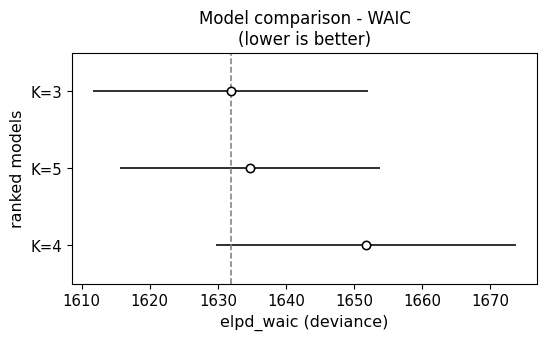


=== Model Comparison (LOO) ===
     rank     elpd_loo     p_loo  elpd_diff    weight         se       dse  \
K=3     0  1631.837227  2.820782   0.000000  0.756534  20.160389  0.000000   
K=5     1  1634.761224  0.410441   2.923997  0.243374  18.969762  2.415095   
K=4     2  1650.955771  9.105359  19.118543  0.000092  21.743365  2.022048   

     warning     scale  
K=3     True  deviance  
K=5     True  deviance  
K=4     True  deviance  


C:\Users\Victus\PycharmProjects\PMP-2024\.venv1\lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than -0.66 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\Victus\PycharmProjects\PMP-2024\.venv1\lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than -0.66 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\Victus\PycharmProjects\

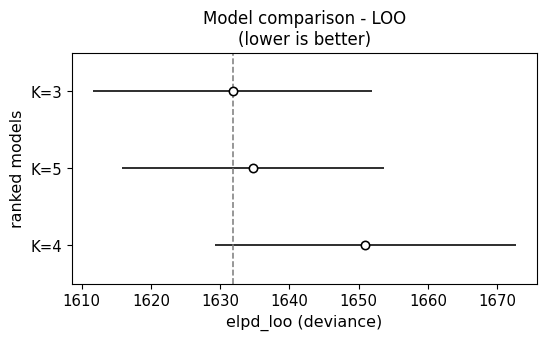

In [62]:
print("\n=== Model Comparison (WAIC) ===")
comparison_waic = az.compare(
    models_traces,  # Pass the dictionary directly
    method='BB-pseudo-BMA',
    ic='waic',
    scale='deviance'
)
print(comparison_waic)

az.plot_compare(comparison_waic)
plt.title("Model comparison - WAIC\n(lower is better)")
plt.show()


print("\n=== Model Comparison (LOO) ===")
comparison_loo = az.compare(
    models_traces,  # Pass the dictionary directly
    method='BB-pseudo-BMA',
    ic='loo',
    scale='deviance'
)
print(comparison_loo)

az.plot_compare(comparison_loo)
plt.title("Model comparison - LOO\n(lower is better)")
plt.show()


In [63]:
# Alegem K optim conform WAIC/LOO
best_K = comparison_waic.index[0]  # WAIC recomandă acest K
print(f"\n=== Best Model Selected: {best_K} ===")

# Extragem trasabilitatea (trace) modelului optim
best_trace = models_traces[best_K]

# Calculăm media a posteriori pentru fiecare subpopulație
mean_weights = best_trace.posterior['mu'].mean(dim=("chain", "draw")).values

# Afișăm rezultatele
print("\n=== Estimated Mean Weights for Each Subpopulation ===")
for i, mu in enumerate(mean_weights):
    print(f"Subpopulation {i+1}: {mu:.2f}")



=== Best Model Selected: K=3 ===

=== Estimated Mean Weights for Each Subpopulation ===
Subpopulation 1: 62.54
Subpopulation 2: 62.93
Subpopulation 3: 62.33


In [64]:
# Calculăm media a posteriori pentru ponderi (w)
mean_weights_proportions = best_trace.posterior['w'].mean(dim=("chain", "draw")).values

# Afișăm rezultatele
print("\n=== Estimated Proportion of Each Subpopulation ===")
for i, w in enumerate(mean_weights_proportions):
    print(f"Subpopulation {i+1}: {w:.2%} of total fish")



=== Estimated Proportion of Each Subpopulation ===
Subpopulation 1: 52.53% of total fish
Subpopulation 2: 28.11% of total fish
Subpopulation 3: 19.36% of total fish


In [65]:
def plot_all_mixture_models(models_traces, data):
    """
    Plots the histogram of the data and overlays the estimated mixture distributions
    for different values of K (3, 4, 5).
    """
    plt.figure(figsize=(10, 6))

    # Plot histogram of data
    plt.hist(data, bins=20, density=True, alpha=0.6, color='blue', edgecolor='black', label='Observed Data')

    # Generate x-axis range for density estimation
    x = np.linspace(data.min(), data.max(), 1000)

    colors = ['red', 'green', 'purple']  # Different colors for each K
    Ks = [3, 4, 5]  # Models to compare

    for i, K in enumerate(Ks):
        trace = models_traces[f"K={K}"]

        # Extract mean posterior estimates
        w_mean = trace.posterior['w'].mean(dim=("chain", "draw")).values
        mu_mean = trace.posterior['mu'].mean(dim=("chain", "draw")).values
        sigma_mean = trace.posterior['sigma'].mean(dim=("chain", "draw")).values

        # Compute the total mixture density
        total_pdf = np.zeros_like(x)
        for k in range(K):
            pdf_k = w_mean[k] * stats.norm.pdf(x, mu_mean[k], sigma_mean[k])
            total_pdf += pdf_k
            plt.plot(x, pdf_k, linestyle='dashed', color=colors[i], alpha=0.7)

        # Plot the overall mixture model for this K
        plt.plot(x, total_pdf, color=colors[i], label=f'Mixture Model (K={K})', linewidth=2)

    plt.xlabel('Weight')
    plt.ylabel('Density')
    plt.title('Comparison of Mixture Models for Different K')
    plt.legend()
    plt.grid(True)
    plt.show()


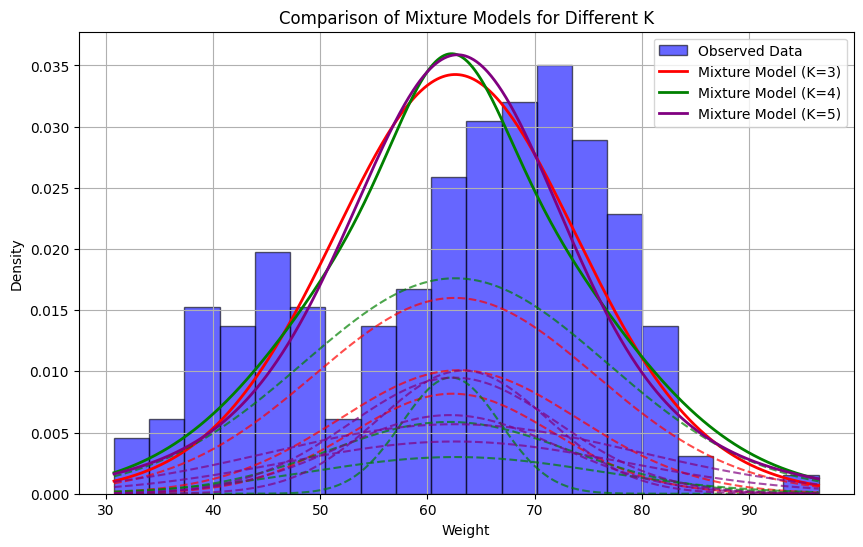

In [66]:
plot_all_mixture_models(models_traces, weights)


Rezultatele obținute pot fi influențate de numărul redus de mostre eșantionate din distribuția a posteriori. Din cauza timpului de execuție limitat, nu am putut rula un număr mai mare de iterații, ceea ce poate afecta precizia estimărilor.